## Dissertação: Frederico Gomes

Autor: Maria Luiza Campos

Data: Setembro 2025

In [10]:
## Importando bibliotecas

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Importando os dados

dados = pd.read_csv('dados_limpos.csv')
print("Dados importados com sucesso!")

Dados importados com sucesso!


In [11]:
## Vamos visualizar o nome das colunas

print(dados.columns)

## Vamos eliminar missing values

colunas = [
    'faixa_etaria_vitima', 
    'faixa_etaria_reu',
    'categoria_vinculo', 
    'coab', 
    'filhos',
    'consentimento_familiar', 
    'consentimento_vitima'
]

dados = dados.dropna(subset=colunas)

print("Tamanho final da amostra:", len(dados))

## Nossa amostra final tem 120 observações completas. 


Index(['ID_processo', 'classe_processual', 'estado', 'ano_fatos',
       'faixa_etaria_vitima', 'faixa_etaria_reu', 'resultado_julgamento',
       'descricao_vinculo', 'categoria_vinculo', 'coab', 'filhos',
       'consentimento_familiar', 'consentimento_vitima', 'aplicacao_sumula'],
      dtype='object')
Tamanho final da amostra: 123


In [12]:
### Vamos criar a matriz de contigência para cada uma das variáveis de interesse

## IDADE DA VÍTIMA

tab_contigencia_1 = pd.crosstab(dados["faixa_etaria_vitima"], dados["resultado_julgamento"])
print(tab_contigencia_1)

## Há zero na tabela de contigência para faixa etária da vítima. Não há absolvição para quando a vítima tem menos de 12 anos. 

## IDADE DO RÉU

tab_contigencia_2 = pd.crosstab(dados["faixa_etaria_reu"], dados["resultado_julgamento"])
print(tab_contigencia_2)

## Há zero na tabela de contigência para faixa etária do réu. Não há absolvição para quando o réu está entre 21 e 24 anos - mas há 12 absolvições para quando o réu tem 25 ou mais anos. 

## CATEGORIA DE VÍNCULO

tab_contigencia_3 = pd.crosstab(dados["categoria_vinculo"], dados["resultado_julgamento"])
print(tab_contigencia_3)

## Há zero na tabela de contigência para categoria de vínculo. Não há absolvição para quando a categoria de vínculo é "Abuso/Não afetivo". 

# COAB

tab_contigencia_4 = pd.crosstab(dados["coab"], dados["resultado_julgamento"])
print(tab_contigencia_4)

## FILHOS

tab_contigencia_5 = pd.crosstab(dados["filhos"], dados["resultado_julgamento"])
print(tab_contigencia_5)

## CONSENTIMENTO FAMILIAR

tab_contigencia_6 = pd.crosstab(dados["consentimento_familiar"], dados["resultado_julgamento"])
print(tab_contigencia_6)

# CONSENTIMENTO DA VÍTIMA

tab_contigencia_7 = pd.crosstab(dados["consentimento_vitima"], dados["resultado_julgamento"])
print(tab_contigencia_7)

## Há zero na tabela de contigência para consentimento da vítima. Não há absolvição para quando a vítima não consentiu. 


resultado_julgamento   0   1
faixa_etaria_vitima         
0.0                    8  48
1.0                   13  54
resultado_julgamento   0   1
faixa_etaria_reu            
0.0                    9  14
1.0                   12  88
resultado_julgamento   0   1
categoria_vinculo           
0                      0  32
1                     21  70
resultado_julgamento   0   1
coab                        
0.0                    5  77
1.0                   16  25
resultado_julgamento   0   1
filhos                      
0.0                    7  90
1.0                   14  12
resultado_julgamento     0   1
consentimento_familiar        
0.0                      9  78
1.0                     12  24
resultado_julgamento   0   1
consentimento_vitima        
0                      0  31
1                     21  71


O zero na tabela de contigência é um problema porque isso indica um Odds Ratio extremo ou instável - há zero casos de absolvição quando x = 0 ou x = 1. Isso é um problema para um modelo de regressão logística e temos esse problema na variável de idade, que precisa ser priorizada. 

A saída é fazer uma manipulação estatística, adicionando 0.5 em cada célula da tabela de contigência (Correção de Haldane-Anscombe) **[REFERÊNCIA]** para eliminar os zeros sem prejudicar muito a interpretação. Assim, podemos usar essa variável na regressão logística, se ela for, de fato, relevante. 

### Como checar a relevância de uma variável?

Iremos fazer uma matriz de correlações para checar se as variáveis são multicolineares. Quando há multicolinearidade, significa que duas variáveis são muito correlacionadas e, assim, 
precisamos escolher apenas uma para compor o modelo final. 

## Montando a matriz de correlações para checar multicolinearidade

Vamos usar uma matriz de correlações calculando o V de Cramer para variáveis categóricas, incluindo variáveis com mais de 2 categorias (como é o caso da idade). Ou seja, esse método é ideal para tabelas de contigência maiores que 2x2.

In [13]:
## Vamos montar a matriz de correlação

## pra isso, precisamos filtrar a base para as variáveis de interesse

colunas_interesse = [
    'ID_processo',
    'faixa_etaria_vitima', 
    'faixa_etaria_reu',
    'categoria_vinculo', 
    'coab', 
    'filhos',
    'consentimento_familiar', 
    'consentimento_vitima',
    "resultado_julgamento"
]

dados_filtrados = dados[colunas_interesse].copy()

In [14]:
## Vamos criar uma função para corrigir os zeros.

## Vamos criar uma função 

def apply_haldane_anscombe(table):
    """
    Aplica a correção de Haldane–Anscombe em uma tabela de contingência.
    Adiciona 0.5 a todas as células apenas se houver pelo menos um zero.
    
    Parâmetros:
        table (pd.DataFrame): Tabela de contingência
    
    Retorna:
        pd.DataFrame: Tabela corrigida
    """
    # Verifica se existe algum zero na tabela
    if (table == 0).any().any():
        table_corrected = table.astype(float) + 0.5
        return table_corrected
    else:
        return table.astype(float)

In [15]:
## Importando algumas bibliotecas

from scipy.stats import chi2_contingency
import numpy as np

## Cálculo do V de Cramer (função)


def cramers_v(table):
    """
    Calcula V de Cramer para uma tabela de contingência corrigida.
    
    table: pd.DataFrame (pode ter sido corrigida com Haldane–Anscombe)
    """
    chi2 = chi2_contingency(table, correction=False)[0]
    n = table.sum().sum()
    r, k = table.shape
    phi2 = chi2 / n
    # Correção de bias
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return v

## Montando a matriz (função)

def cramers_v_matrix(df):
    """
    Calcula a matriz de V de Cramer entre todas as variáveis categóricas de um DataFrame.
    
    df: pd.DataFrame com todas as variáveis categóricas (binárias ou multiclasse)
    
    Retorna: pd.DataFrame com valores de V de Cramer
    """
    cols = df.columns
    n = len(cols)
    result = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
    
    for i in range(n):
        for j in range(i, n):
            # Cria a tabela de contingência
            table = pd.crosstab(df[cols[i]], df[cols[j]])
            # Aplica correção Haldane–Anscombe se houver zero
            table = apply_haldane_anscombe(table)
            # Calcula V de Cramer
            v = cramers_v(table)
            # Preenche matriz
            result.iloc[i, j] = v
            result.iloc[j, i] = v
    return result

In [8]:
## Aplicando

matriz_v = cramers_v_matrix(dados_filtrados)
print(matriz_v)


                        ID_processo  faixa_etaria_vitima  faixa_etaria_reu  \
ID_processo                     0.0             0.000000          0.000000   
faixa_etaria_vitima             0.0             0.983743          0.050331   
faixa_etaria_reu                0.0             0.050331          0.974004   
categoria_vinculo               0.0             0.138368          0.219782   
coab                            0.0             0.089407          0.049757   
filhos                          0.0             0.124394          0.061307   
consentimento_familiar          0.0             0.000000          0.000000   
consentimento_vitima            0.0             0.160528          0.212700   
resultado_julgamento            0.0             0.000000          0.267253   

                        categoria_vinculo      coab    filhos  \
ID_processo                      0.000000  0.000000  0.000000   
faixa_etaria_vitima              0.138368  0.089407  0.124394   
faixa_etaria_reu        

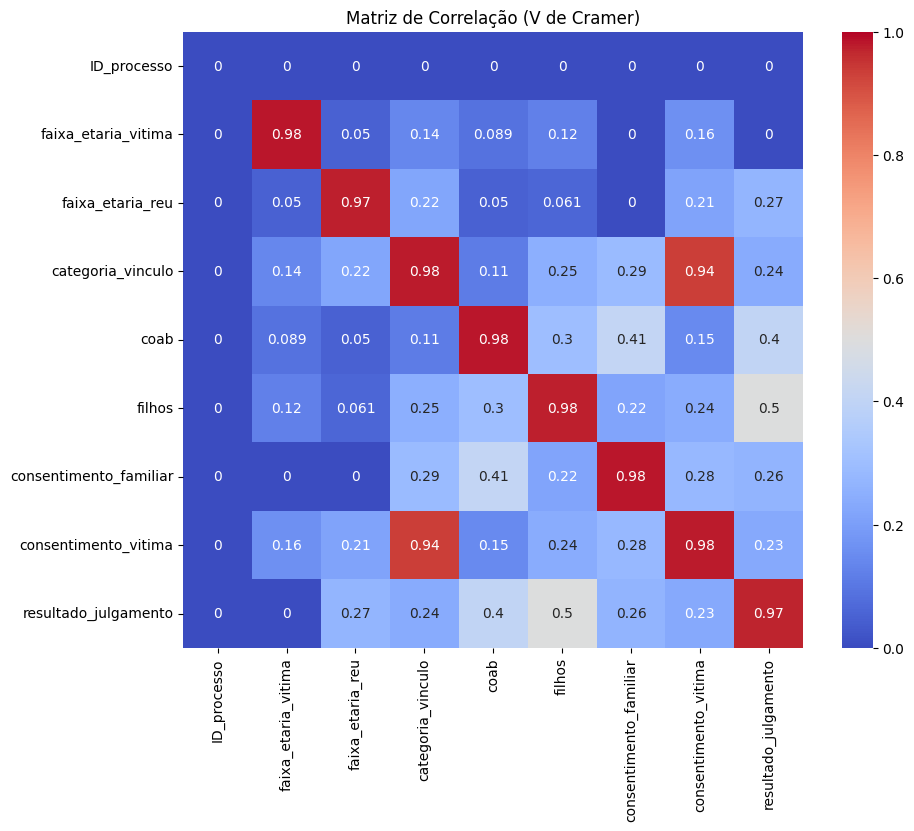

In [16]:
## melhor visualização

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(matriz_v, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Matriz de Correlação (V de Cramer)")
plt.show()

## Variáveis principais a serem inclusas no modelo final: faixa etária da vítima, faixa etária do réu, filhos, consentimento familiar. 

## Modelo de Regressão Logística

In [17]:
# Selecionar variáveis de interesse

variaveis = ["faixa_etaria_vitima", "faixa_etaria_reu", "filhos", "consentimento_familiar"]
X = dados[variaveis]
y = dados["resultado_julgamento"]

# Garantir que X é numérico

X = X.astype(float)

# Adicionar constante (intercepto) ao modelo

X = sm.add_constant(X)

# Rodar regressão logística

modelo = sm.Logit(y, X).fit()

# Resumo dos resultados

print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.303063
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     resultado_julgamento   No. Observations:                  123
Model:                            Logit   Df Residuals:                      118
Method:                             MLE   Df Model:                            4
Date:                  Wed, 10 Sep 2025   Pseudo R-squ.:                  0.3369
Time:                          20:32:47   Log-Likelihood:                -37.277
converged:                         True   LL-Null:                       -56.216
Covariance Type:              nonrobust   LLR p-value:                 1.187e-07
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.6897      0.702      2.406      0.016  

In [22]:
## exportando tabela

from stargazer.stargazer import Stargazer

# modelo = seu objeto statsmodels.Logit
stargazer = Stargazer([modelo])

# Gerar HTML
html_code = stargazer.render_html()

# Salvar em arquivo local
with open("tabela_modelo.html", "w", encoding="utf-8") as f:
    f.write(html_code)